# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
#local env installation
!pip install keras-flops

!pip install tensorflow
!pip install tensorflow_datasets
!pip install matplotlib
!pip install opencv-python
!pip install pandas
!pip install sklearn
!pip install glob2
!pip install Keras-Preprocessing
!pip install numpy
!pip install Image

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.utils.vis_utils import plot_model
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from keras_flops import get_flops
import os
import glob
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from PIL import Image

tf.enable_v2_behavior()

BATCH_SIZE = 32
NUM_EPOCHS = 25
NUM_CLASSES = 2  # 2 total classes.
LEARNING_RATE = [0.0001, 0.001, 0.001]

In [ ]:
import os
import tensorflow as tf
import tensorflow.python.keras.backend as KTF

os.environ["CUDA_VISIBLE_DEVICES"]="0" 
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9 #90% GPU-MEM
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

# setup session
KTF.set_session(session)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 431863421911456918
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6977748992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16158119201532191721
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:08:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data loading

In [ ]:
project_path = "G:/Onedrive/University of Toronto/ECE1512H/"

In [ ]:
import pandas as pd
pd.set_option("max_colwidth", -1)

annotations = pd.read_csv(project_path + "ProjectB/Project_B_Supp/Project_B_Supp/mhist_dataset/annotations.csv", skiprows=1,
    names=["Image Name", "Majority Vote Label", "Number of Annotators who Selected SSA (Out of 7)", "Partition"])

annotations.head()

C:\Users\LunarSS\AppData\Local\Temp/ipykernel_11628/3244531851.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("max_colwidth", -1)


,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [ ]:
# Create a DataFrame object from list 
df = pd.DataFrame(annotations, 
                columns =["Image Name", "Majority Vote Label", "Number of Annotators who Selected SSA (Out of 7)", "Partition"])
df.set_index("Image Name", inplace = True)

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random

def create_imgs_and_labels(files, note, ratio):
    imgs_arr = []
    labels = []
    # create image data augmentation generator
    datagen = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          rotation_range=180)

    for img in files:
      img_name = img.split('\\')[1].strip()
      # print(img_name)
      
      if df.loc[img_name][2] == note:
        img_data = img_to_array(load_img(img, target_size=IMG_DIM))
        label = df.loc[img_name][0]
        imgs_arr.append(img_data)
        labels.append(label)
        if ratio == 1:
          continue

        # expand dimension to one sample
        samples = expand_dims(img_data, 0)
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot
        for i in range(1, ratio):
          if not random.randint(1,10)%5:
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            imgs_arr.append(image)
            # print(label)
            labels.append(label)
          
    return imgs_arr, labels

In [ ]:
IMG_DIM = (224, 224)

img_files = glob.glob(project_path + "ProjectB/Project_B_Supp/Project_B_Supp/mhist_dataset/images/images/*")
# img_files[0].split('\\')[1]
train_imgs, train_labels = create_imgs_and_labels(img_files, "train", 2)
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

test_imgs, test_labels = create_imgs_and_labels(img_files, "test", 1)
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

print('Train dataset shape:', train_imgs.shape, 
      '\tTest dataset shape:', test_imgs.shape)

Train dataset shape: (2589, 224, 224, 3) 	Test dataset shape: (977, 224, 224, 3)


In [ ]:
train_imgs_scaled = train_imgs.astype("float32") / 255.0
test_imgs_scaled = test_imgs.astype("float32") / 255.0

In [ ]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)
print(train_labels[1000:1020], "\n", train_labels_enc[1000:1020])

['HP' 'HP' 'HP' 'HP' 'HP' 'HP' 'HP' 'HP' 'HP' 'SSA' 'SSA' 'HP' 'HP' 'SSA'
 'HP' 'HP' 'SSA' 'HP' 'HP' 'HP'] 
 [0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0]


# Model creation

In [ ]:
from tensorflow.keras.models import Model

# Build CNN teacher.
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Build fully connected student.
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions


# Build teacher.
def new_teacher():
  # resnet_model = keras.applications.resnet_v2.ResNet50V2()
  resnet_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

  resnet_model.trainable = False
  # for layer in resnet_model.layers:
  #   layer.trainable = False

  x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
  x = tf.keras.layers.Dense(2, activation="softmax")(x)
  teacher = Model(inputs=resnet_model.input, outputs=x)
  return teacher

# Build student.
def new_student():
  # mobile_model = keras.applications.mobilenet_v2.MobileNetV2()
  mobile_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

  mobile_model.trainable = False
  # for layer in mobile_model.layers:
  #   layer.trainable = False

  x = tf.keras.layers.GlobalAveragePooling2D()(mobile_model.output)
  x = tf.keras.layers.Dense(2, activation="softmax")(x)
  student = Model(inputs=mobile_model.input, outputs=x)
  return student

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=4,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        # return results
        return y_prediction

In [ ]:
def get_f1_score(model, note):
  y_pred = np.rint(model.predict(test_imgs_scaled))

  f1_score_out = f1_score(test_labels_enc, np.argmax(y_pred, axis=1), average=note)
  return f1_score_out

In [ ]:
def get_auc_score(model, note):
  y_pred = np.rint(model.predict(test_imgs_scaled))

  auc_score_out = roc_auc_score(test_labels_enc, np.argmax(y_pred, axis=1), average=note)
  return auc_score_out

In [ ]:
# from numpy import savetxt
# save data sets
# save to npy file

np.save(project_path + "ProjectB/datasets/train_imgs.npy", train_imgs_scaled)
np.save(project_path + "ProjectB/datasets/train_labels.npy", train_labels)
np.save(project_path + "ProjectB/datasets/test_imgs.npy", test_imgs_scaled)
np.save(project_path + "ProjectB/datasets/test_labels.npy", test_labels)

# Training models

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

# teacher for training
teacher = new_teacher()

# student_scratch for later comparison
student_scratch = new_student()

T = [1,2,4,16,32,64]
Alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

students_T = []
students_T_f1 = []
students_T_auc = []

# students_alpha = []
# students_alpha_f1 = []
# students_alpha_auc = []


for i in range(len(T)):
  # teachers_T.append(keras.models.clone_model(teacher))
  students_T.append(new_student())

# for i in range(9):
#   # teachers_alpha.append(keras.models.clone_model(teacher))
#   students_alpha.append(new_student())

# Train and evaluation

In [ ]:
# Train student from scratch for comparison
# Train student as doen usually
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[2]),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train student trained from scratch.
student_scratch.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)
student_scratch.save(project_path + "ProjectB/saved_model/student_scratch_model") 

Epoch 1/25
81/81 [==============================] - 8s 34ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.7377
Epoch 2/25
81/81 [==============================] - 3s 33ms/step - loss: 0.4148 - sparse_categorical_accuracy: 0.8092
Epoch 3/25
81/81 [==============================] - 3s 34ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8142
Epoch 4/25
81/81 [==============================] - 3s 34ms/step - loss: 0.3676 - sparse_categorical_accuracy: 0.8331
Epoch 5/25
81/81 [==============================] - 3s 34ms/step - loss: 0.3527 - sparse_categorical_accuracy: 0.8382
Epoch 6/25
81/81 [==============================] - 3s 34ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.8447
Epoch 7/25
81/81 [==============================] - 3s 33ms/step - loss: 0.3280 - sparse_categorical_accuracy: 0.8528
Epoch 8/25
81/81 [==============================] - 3s 33ms/step - loss: 0.3191 - sparse_categorical_accuracy: 0.8567
Epoch 9/25
81/81 [==============================] - 3s 3

In [ ]:
student_scratch_f1 = get_f1_score(student_scratch, "weighted")
student_scratch_f1

0.7765228961674391

In [ ]:
student_scratch_auc = get_auc_score(student_scratch, "weighted")
student_scratch_auc

0.7623626868359445

In [ ]:
# your code start from here for step 5 
# Train the teacher
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[0]),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train teacher on data.
teacher.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)
teacher.save(project_path + "ProjectB/saved_model/teacher_model") 

Epoch 1/25
81/81 [==============================] - 7s 59ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.6868
Epoch 2/25
81/81 [==============================] - 5s 56ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.7281
Epoch 3/25
81/81 [==============================] - 5s 59ms/step - loss: 0.5052 - sparse_categorical_accuracy: 0.7451
Epoch 4/25
81/81 [==============================] - 4s 55ms/step - loss: 0.4747 - sparse_categorical_accuracy: 0.7679
Epoch 5/25
81/81 [==============================] - 5s 57ms/step - loss: 0.4524 - sparse_categorical_accuracy: 0.7829
Epoch 6/25
81/81 [==============================] - 5s 57ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.7922
Epoch 7/25
81/81 [==============================] - 5s 56ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8034
Epoch 8/25
81/81 [==============================] - 5s 56ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8100
Epoch 9/25
81/81 [==============================] - 5s 5

In [ ]:
teacher_f1 = get_f1_score(teacher, "weighted")
teacher_f1

0.8110113916725177

In [ ]:
teacher_auc = get_auc_score(teacher, "weighted")
teacher_auc

0.787718350441203

In [ ]:
# # avoid OOM error
# loop_T = 0
# interval = 2

In [ ]:
# Distill teacher to student
for i in range(len(T)):
# for i in range(loop_T, loop_T+interval):
  # Initialize and compile distiller
  distiller = Distiller(student=students_T[i], teacher=teacher)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[1]),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=0.5,
      temperature=T[i],
  )

  # Distill teacher to student
  distiller.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)

  students_T_f1.append(get_f1_score(students_T[i], "weighted"))
  students_T_auc.append(get_auc_score(students_T[i], "weighted"))

# loop_T += interval

Epoch 1/25
81/81 [==============================] - 9s 83ms/step - sparse_categorical_accuracy: 0.7648 - student_loss: 0.4837 - distillation_loss: 0.0255
Epoch 2/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8150 - student_loss: 0.4057 - distillation_loss: 0.0204
Epoch 3/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8185 - student_loss: 0.3880 - distillation_loss: 0.0207
Epoch 4/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8312 - student_loss: 0.3618 - distillation_loss: 0.0189
Epoch 5/25
81/81 [==============================] - 7s 82ms/step - sparse_categorical_accuracy: 0.8385 - student_loss: 0.3446 - distillation_loss: 0.0182
Epoch 6/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8409 - student_loss: 0.3395 - distillation_loss: 0.0181
Epoch 7/25
81/81 [==============================] - 7s 82ms/step - sparse_ca

In [ ]:
# save student models
for i in range(len(T)):
  students_T[i].save(project_path + "ProjectB/saved_model/student_T" + str(T[i]) + "_model")

INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T1_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T2_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T4_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T16_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T32_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_T64_model\assets


In [ ]:
# find maximum f1 score
max_f1_T_index = -1
max_f1_T = 0
for i in range(len(students_T_f1)):
  if students_T_f1[i] > max_f1_T:
    max_f1_T = students_T_f1[i]
    max_f1_T_index = i

In [ ]:
max_f1_T_index

1

In [ ]:
max_f1_T

0.7829728255303454

In [ ]:
T

[1, 2, 4, 16, 32, 64]

In [ ]:
students_T_f1

[0.7693626221808308,
 0.7829728255303454,
 0.7657247738561334,
 0.7687193938761411,
 0.7715522316920543,
 0.773833086215459]

In [ ]:
students_T_auc

[0.7511367729155412,
 0.775670808571943,
 0.7333198271204755,
 0.7414190527642716,
 0.7459323788942913,
 0.746627948856474]

In [ ]:
students_alpha = []
students_alpha_f1 = []
students_alpha_auc = []

for i in range(9):
  # teachers_alpha.append(keras.models.clone_model(teacher))
  students_alpha.append(new_student())

In [ ]:
# Distill teacher to student
for i in range(4):
  # Initialize and compile distiller
  distiller = Distiller(student=students_alpha[i], teacher=teacher)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[1]),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=Alpha[i],
      temperature=T[max_f1_T_index],
  )

  # Distill teacher to student
  distiller.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)

  students_alpha_f1.append(get_f1_score(students_alpha[i], "weighted"))
  students_alpha_auc.append(get_auc_score(students_alpha[i], "weighted"))

Epoch 1/25
81/81 [==============================] - 9s 81ms/step - sparse_categorical_accuracy: 0.7601 - student_loss: 0.4902 - distillation_loss: 0.0070
Epoch 2/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8065 - student_loss: 0.4038 - distillation_loss: 0.0051
Epoch 3/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8239 - student_loss: 0.3799 - distillation_loss: 0.0048
Epoch 4/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8355 - student_loss: 0.3573 - distillation_loss: 0.0043
Epoch 5/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8405 - student_loss: 0.3495 - distillation_loss: 0.0044
Epoch 6/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8501 - student_loss: 0.3353 - distillation_loss: 0.0042
Epoch 7/25
81/81 [==============================] - 7s 81ms/step - sparse_ca

In [ ]:
# save student models
for i in range(4):
  students_alpha[i].save(project_path + "ProjectB/saved_model/student_alpha_" + str((i+1)/10.0) + "_model")

INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.1_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.2_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.3_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.4_model\assets


In [ ]:
# add alpha 0.5 scores
students_alpha_f1.append(students_T_f1[max_f1_T_index])
students_alpha_auc.append(students_T_auc[max_f1_T_index])

In [ ]:
# Distill teacher to student
for i in range(5):
  alpha_index = i + 4
  # Initialize and compile distiller
  distiller = Distiller(student=students_alpha[alpha_index], teacher=teacher)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[1]),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=Alpha[alpha_index+1],
      temperature=T[max_f1_T_index],
  )

  # Distill teacher to student
  distiller.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)

  students_alpha_f1.append(get_f1_score(students_alpha[alpha_index], "weighted"))
  students_alpha_auc.append(get_auc_score(students_alpha[alpha_index], "weighted"))

Epoch 1/25
81/81 [==============================] - 9s 81ms/step - sparse_categorical_accuracy: 0.7609 - student_loss: 0.5011 - distillation_loss: 0.0079
Epoch 2/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8049 - student_loss: 0.4096 - distillation_loss: 0.0056
Epoch 3/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8277 - student_loss: 0.3754 - distillation_loss: 0.0052
Epoch 4/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8378 - student_loss: 0.3551 - distillation_loss: 0.0048
Epoch 5/25
81/81 [==============================] - 7s 82ms/step - sparse_categorical_accuracy: 0.8478 - student_loss: 0.3435 - distillation_loss: 0.0048
Epoch 6/25
81/81 [==============================] - 7s 81ms/step - sparse_categorical_accuracy: 0.8582 - student_loss: 0.3350 - distillation_loss: 0.0048
Epoch 7/25
81/81 [==============================] - 7s 81ms/step - sparse_ca

In [ ]:
# save student models
for i in range(4,9):
  students_alpha[i].save(project_path + "ProjectB/saved_model/student_alpha_" + str((i+2)/10.0) + "_model")

INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.6_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.7_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.8_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_0.9_model\assets
INFO:tensorflow:Assets written to: G:/Onedrive/University of Toronto/ECE1512H/ProjectB/saved_model/student_alpha_1.0_model\assets


In [ ]:
# find maximum f1 score
max_f1_alpha_index = -1
max_f1_alpha = 0
for i in range(len(students_alpha_f1)):
  if students_alpha_f1[i] > max_f1_alpha:
    max_f1_alpha = students_alpha_f1[i]
    max_f1_alpha_index = i

In [ ]:
max_f1_alpha_index

0

In [ ]:
max_f1_alpha

0.7834872514321238

In [ ]:
students_alpha_f1

[0.7834872514321238,
 0.7777738371510889,
 0.7792885104268722,
 0.7463280285002964,
 0.7829728255303454,
 0.7716476264838091,
 0.7682933699029352,
 0.7821178343724079,
 0.7762914583526758,
 0.7552422616519294]

In [ ]:
students_alpha_auc

[0.7735886007563479,
 0.7483657482441923,
 0.7642152890329552,
 0.7049680352962363,
 0.775670808571943,
 0.7485931028273005,
 0.7366761210156672,
 0.770464163515217,
 0.7198946515397082]

In [ ]:
import sys
sys.path.append(project_path + "ProjectB")
# sys.path

In [ ]:
from xai_utils import *

def xai_explanation(model, image, layer):
  cam = grad_cam(model, np.expand_dims(image, axis=0), layer)
  print(cam.shape)
  cam = (cam*255).astype("uint8")
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  img = cam + image
  img = np.clip(img,0,255).astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image.reshape(224,224,3))
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')

xai on teacher model
(224, 224)


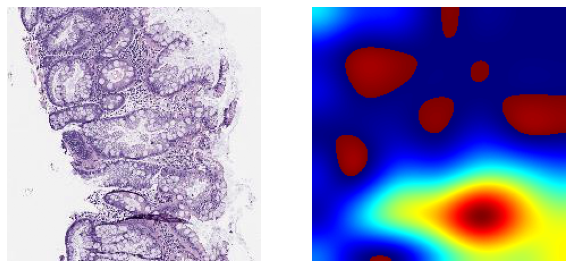

In [ ]:
test_img = test_imgs_scaled[0]
print("xai on teacher model")
teacher_xai = xai_explanation(teacher, test_img, "conv5_block3_3_conv")

xai on student_scratch model
(224, 224)


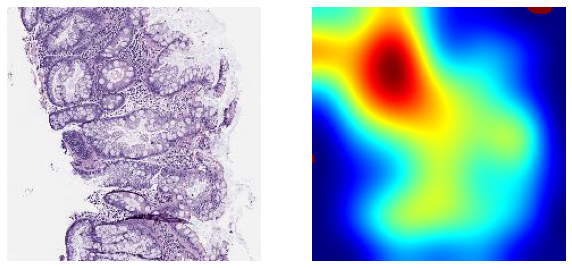

In [ ]:
print("xai on student_scratch model")
student_scratch_xai = xai_explanation(student_scratch, test_img, "Conv_1")

xai on student_distill with best score model
(224, 224)


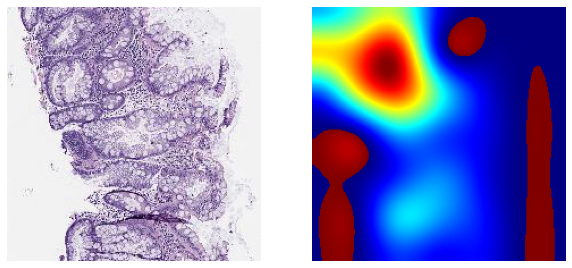

In [ ]:
print("xai on student_distill with best f1 score model")
student_distill_xai = xai_explanation(students_alpha[max_f1_alpha_index], test_img, "Conv_1")

In [ ]:
flops = get_flops(teacher, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 6.99 G


In [ ]:
flops = get_flops(student_scratch, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.613 G


In [ ]:
flops = get_flops(students_alpha[max_f1_alpha_index], batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.613 G


In [ ]:
# build ta model
resnet_raw = keras.applications.resnet_v2.ResNet50V2(weights="imagenet", input_shape=(224, 224, 3))
resnet_raw.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(resnet_raw.layers[-34].output)
x = tf.keras.layers.Dense(2, activation="softmax")(x)
ta_model = Model(inputs=resnet_raw.input, outputs=x)

ta_layers = [(layer, layer.name, layer.trainable) for layer in ta_model.layers]
pd.DataFrame(ta_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001538E488850>,input_60,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x000001539E9308B0>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x00000154B554A670>,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D object at 0x00000154B53AE070>,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0x00000153A0E32DC0>,pool1_pool,False
...,...,...,...
156,<keras.layers.convolutional.Conv2D object at 0x000001524B1A1CA0>,conv5_block1_1_conv,False
157,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000015499B4BC10>,conv5_block1_1_bn,False
158,<keras.layers.core.activation.Activation object at 0x0000015499CE7A00>,conv5_block1_1_relu,False
159,<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000154C677E670>,global_average_pooling2d_54,True


In [ ]:
# train ta_model
distiller = Distiller(student=ta_model, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[1]),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=Alpha[max_f1_alpha_index],
    temperature=T[max_f1_T_index],
)

# Distill teacher to student
distiller.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)
ta_model.save(project_path + "ProjectB/saved_model/ta_model") 

Epoch 1/25
81/81 [==============================] - 11s 103ms/step - sparse_categorical_accuracy: 0.6964 - student_loss: 0.5788 - distillation_loss: 0.0093
Epoch 2/25
81/81 [==============================] - 8s 100ms/step - sparse_categorical_accuracy: 0.7312 - student_loss: 0.5117 - distillation_loss: 0.0064
Epoch 3/25
81/81 [==============================] - 8s 97ms/step - sparse_categorical_accuracy: 0.7683 - student_loss: 0.4831 - distillation_loss: 0.0054
Epoch 4/25
81/81 [==============================] - 8s 97ms/step - sparse_categorical_accuracy: 0.7779 - student_loss: 0.4642 - distillation_loss: 0.0047
Epoch 5/25
81/81 [==============================] - 8s 97ms/step - sparse_categorical_accuracy: 0.7876 - student_loss: 0.4516 - distillation_loss: 0.0043
Epoch 6/25
81/81 [==============================] - 8s 97ms/step - sparse_categorical_accuracy: 0.7895 - student_loss: 0.4438 - distillation_loss: 0.0042
Epoch 7/25
81/81 [==============================] - 8s 97ms/step - sparse

In [ ]:
ta_f1 = get_f1_score(ta_model, "weighted")
ta_f1

0.8033157482869916

In [ ]:
ta_auc = get_auc_score(ta_model, "weighted")
ta_auc

0.7681636052584189

In [ ]:
student_ta = new_student()

# train a new student with ta_model
distiller = Distiller(student=student_ta, teacher=ta_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE[1]),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=Alpha[max_f1_alpha_index],
    temperature=T[max_f1_T_index],
)

# Distill teacher to student
distiller.fit(train_imgs_scaled, train_labels_enc, epochs=NUM_EPOCHS)
student_ta.save(project_path + "ProjectB/saved_model/student_ta_model") 

Epoch 1/25
81/81 [==============================] - 8s 73ms/step - sparse_categorical_accuracy: 0.7516 - student_loss: 0.5058 - distillation_loss: 0.0057
Epoch 2/25
81/81 [==============================] - 6s 73ms/step - sparse_categorical_accuracy: 0.8104 - student_loss: 0.4092 - distillation_loss: 0.0036
Epoch 3/25
81/81 [==============================] - 6s 73ms/step - sparse_categorical_accuracy: 0.8231 - student_loss: 0.3819 - distillation_loss: 0.0034
Epoch 4/25
81/81 [==============================] - 6s 73ms/step - sparse_categorical_accuracy: 0.8382 - student_loss: 0.3663 - distillation_loss: 0.0034
Epoch 5/25
81/81 [==============================] - 6s 73ms/step - sparse_categorical_accuracy: 0.8382 - student_loss: 0.3484 - distillation_loss: 0.0033
Epoch 6/25
81/81 [==============================] - 6s 73ms/step - sparse_categorical_accuracy: 0.8467 - student_loss: 0.3391 - distillation_loss: 0.0032
Epoch 7/25
81/81 [==============================] - 6s 73ms/step - sparse_ca

In [ ]:
student_ta_f1 = get_f1_score(student_ta, "weighted")
student_ta_f1

0.7699002569530645

In [ ]:
student_ta_auc = get_auc_score(student_ta, "weighted")
student_ta_auc

0.7392220421393841

In [ ]:
student_scratch_f1

0.7765228961674391

In [ ]:
# load saved data
teacher_load = keras.models.load_model(project_path + "ProjectB/saved_model/teacher_model")
student_scratch_load = keras.models.load_model(project_path + "ProjectB/saved_model/student_scratch_model")
# test_imgs_npy = np.load(project_path + "ProjectB/datasets/test_imgs.npy")
# test_labels_npy = np.load(project_path + "ProjectB/datasets/test_labels.npy")

# y_pred_flat = []
# y_pred = np.rint(student_scratch_load.predict(test_imgs_npy.astype("float32") / 255.0))

# for i in range(len(y_pred)):
#   if y_pred[i][0]:
#     y_pred_flat.append(0)
#   else:
#     y_pred_flat.append(1)

# y_pred_flat = np.array(y_pred_flat)
# y_pred_flat

In [ ]:
teacher_load.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
student_scratch_load.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

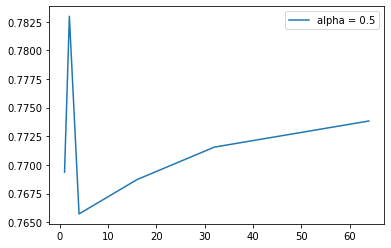

In [ ]:
T = [1,2,4,16,32,64]
Alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
handles = []

students_T = [0.7693626221808308,
 0.7829728255303454,
 0.7657247738561334,
 0.7687193938761411,
 0.7715522316920543,
 0.773833086215459]

students_alpha = [0.7834872514321238,
 0.7777738371510889,
 0.7792885104268722,
 0.7463280285002964,
 0.7829728255303454,
 0.7716476264838091,
 0.7682933699029352,
 0.7821178343724079,
 0.7762914583526758,
 0.7552422616519294]

temp, = plt.plot(T, students_T, label=f'alpha = 0.5')
handles.append(temp)

plt.legend(handles=handles)
plt.show()

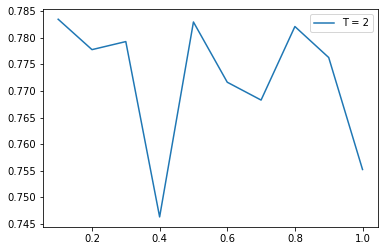

In [ ]:
handles = []
temp, = plt.plot(Alpha, students_alpha, label=f'T = 2')
handles.append(temp)

plt.legend(handles=handles)
plt.show()

# Task 2 Answers

# 1(a) How can we adapt these models for the MHIST dataset using transfer learning? Talk about the Feature Extraction and Fine-Tuning processes during transfer learning. [0.5 Marks]

Since we are using pre-trained model, we can make use of feature extraction and fine-tuning which are famous in transfer learning technique. For a pre-trained model, it already provides suitable weights and enough features trained from plenty of images, we only have to train our own layers based on those complete, mature pre-trained model with a very small dataset. 

In practice, we freeze the pre-trained model to extract features for later training. Then we add new layers upon the existing model for fine-tuning. As we know, fine-tuning is working throughout the whole process of training new layers and update weights. Thus, transfer learning not only save time to train, but also improves accuracy compared to training a new model with insufficient dataset resource.

# 1(b) What is a residual block in ResNet architectures? [0.5 Marks]

A residual block is a sequence of layers including a complete skip-connection addition from the last block, following a non-linear activation operation. It supports accurate loss even if the number of layers in the network is very big.

# 1(c) What are the differences between the ResNetV1 and ResNetV2 architectures? [0.5 Marks]

See the figure shown below, LHS structure is ResNetV1 and RHS structure is ResNetV2. The major difference is the activation order. 

V1 uses post-activation where ReLU is placed after conv layer and BN which follows the regular order of conv -> BN ->ReLU that is the mostly used in deep learning. But V2 uses pre-activation that uses ReLU before conv layer and normalize the input at the very beginning for regularization, with a good identity mapping and makes the residual block more independent, easier for shortcut connection.


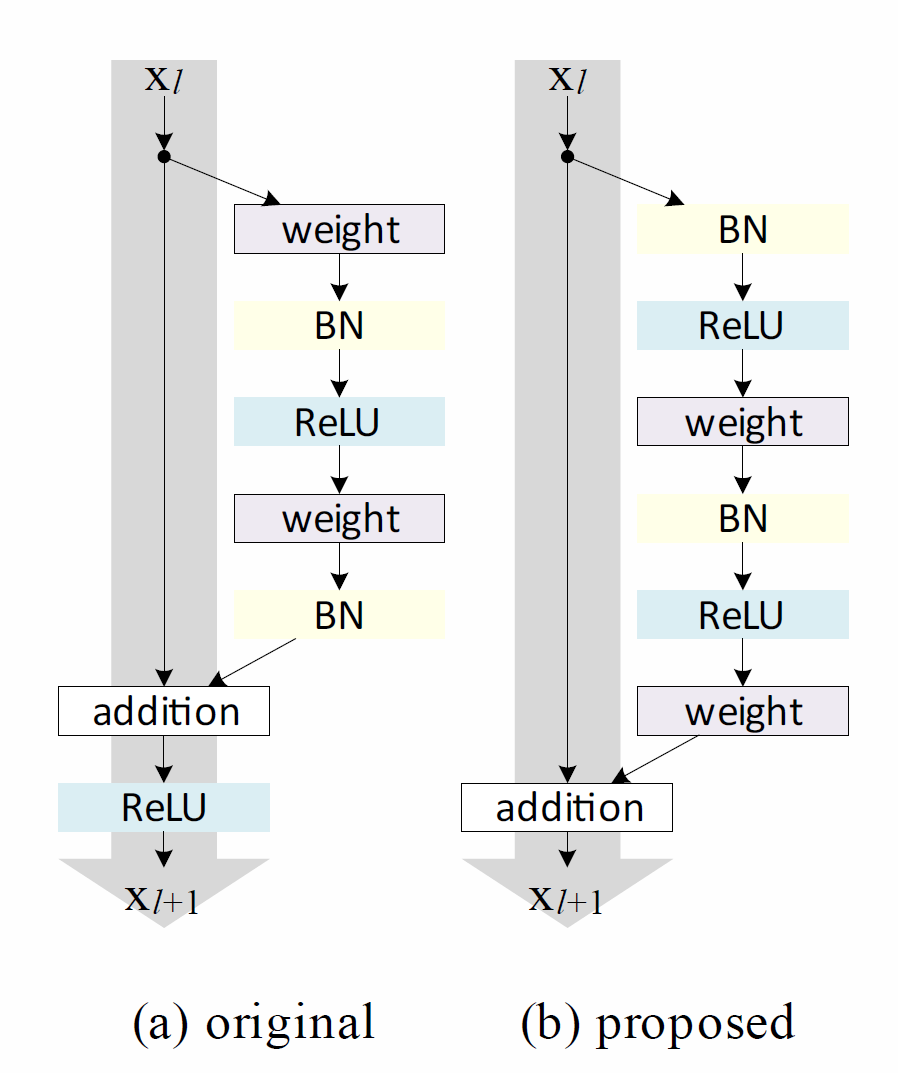

# 1(d) What are the differences between the MobileNetV1 and MobileNetV2 architectures? [0.5 Marks]

MobileNetV1 introduces a new method to divide a 3-dimensional convolution into a pointwise convolution and depthwise convolution. It redueces the number of parameters to process during the training so that it speeds up the training process.

MobileNetV2 makes improvement on residual connection based on V1. It uses inverted residuals scheme to be able to add more layers, making the network deeper.

V2 uses linear bottleneck scheme that replaces the last activation layer from ReLU(non-linear) to a linear alternative because ReLU causes kernel values to be 0 sometimes in the training, especially in low dimensional layers, in other words, arises feature loss. It's a compensation of using pointwise and depthwise convolution.

V2 uses expansion layer scheme to enable convolution on higher channel, first increase dimension, then performs convolution and at last decreases dimension.


# 1(e) How can ResNet architectures, regardless of model depth, overcome the vanishing gradient problem? [0.5 Marks]

ResNet provides a important feature that can transfer one layer's outcome directly, not only to the next layer but also to a much later layer, with identity mapping(not weighted). So that a deep layer can still have access to the information from a very early layer. This feature supports the network depth(number of layers) to be very large(hundreds of layers) without worrying about gradient vanishing and feature loss.

# 1(f) Is MobileNetV2 a lightweight model? Why? [0.5 Marks]

MobileNetV2 is a lightweight model.

As we know, depthwise and pointwise in MobileNetV2 decreases the number of parameters and steps needed in the network training. The purpose of reducing channels, replacing single large-scaled convolution with multiple small convolutions both supports the character of lightweight model.

A lightweight model like MobileNetV2 is usually trained using knowledge distillation by a heavyweight model to improve performance.

In addition, MobileNetV2 is designed for edge devices that.

# 3. Explain the effect of transfer learning and knowledge distillation in the performance of the student model. Do pre-trained weights help the teacher and student models perform well on the MHIST dataset? Does knowledge transfer from the teacher to the student model increase the student’s performance? [2 Marks]

Transfer learning utilizes the information in the pre-trained model and transfers it to fit the new model, which is very much possible a customized one. Knowledge distillation is a method that a heavy weight acts as a teacher to assist student model from generating negative loss feedbacks during knowledge distillation.

In fact, pre-trained weights do help the teacher and student models perform well on MHIST dataset. I tried to run both models with all weights initialized upon HMIST dataset, but got a bad result since the training set is too small.

As we see in the process of knowledge distillation, the f1 score of teacher model is about 0.811 and student model's score is about 0.776. After distillation, we have a best score with T=2 and alpha=0.1 for a new trained student assisted by teacher of about 0.783, which shows a decent increase of student performance.